In [2]:
import math
import os
import glob
import csv
import shutil

import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones
from numpy import exp, linspace, random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText

from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a

from uncertainties import unumpy
from uncertainties import ufloat

import pylab as plb

from scipy.optimize import curve_fit
from scipy.optimize import leastsq as lmfitter
from scipy import signal
from scipy import asarray as ar,exp
from scipy.stats import chisquare
from scipy.stats import stats
from scipy.integrate import quad
from scipy.stats import linregress

import scipy.io
import scipy.integrate as integrate

from IPython.display import display, Math

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

import sherpa.ui as ui
import pandas as pd
from sklearn.linear_model import LinearRegression

from marvin.tools.maps import Maps
from marvin.utils.general.images import showImage
from marvin.tools.cube import Cube

%matplotlib inline

#Emission Lines (Vacuum)

OVI = 1033.82 
Ly_Alpha = 1215.24  
NV = 1240.81  
OI = 1305.53  
CII = 1335.31  
Si_IV = 1397.61  
Si_IV_O_IV = 1399.8  
CIV = 1549.48  
He_II = 1640.4
OIII = 1665.85 
Al_III = 1857.4 
CIII = 1908.734 
CII = 2326.0 
Ne_IV = 2439.5 
Mg_II = 2799.117 
Ne_V = 3346.79 #*
Ne_VI = 3426.85 
Fe_VII_1 = 3586 #*
OII_1 = 3727.092 ###
OII_2 = 3729.875  
Fe_VII_2 = 3760 #*
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
Fe_VII_3 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  ###
Fe_X = 6374 #* Very hard to detect because it is so weak. 
NI = 6529.03  
NII = 6549.86 
H_Alpha = 6564.614  
NII = 6585.27  
SII = 6718.29  
SII = 6732.67  

#Absorption Lines

K = 3934.777  
H = 3969.588 
G = 4305.61  
Mg = 5176.7  
Na = 5895.6  
CaII_1 = 8500.36  
CaII_2 = 8544.44  
CaII_3 = 8664.52  

#Sky Lines

Sky_1 = 5578.5 
Sky_2 = 5894.6  
Sky_3 = 6301.7  
Sky_4 = 7246.0 

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
INFO: No release version set. Setting default to MPL-7


/anaconda3/lib/python3.6/site-packages/marvin/__init__.py:283: MarvinUserWarning: path /Users/jmsnegus/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None.
  .format(value), MarvinUserWarning)
/anaconda3/lib/python3.6/site-packages/marvin/__init__.py:144: UserWarning: your .netrc file has not 600 permissions. Please fix it by running chmod 600 ~/.netrc. Authentication will not work with permissions different from 600.
  warnings.warn('your .netrc file has not 600 permissions. Please fix it by '


In [ ]:
#Creating .txt file for table that lists emission line parameters
#for fitsName in glob.glob('cg/vor10/*.fits'):

# def emission_1(em):
#     f= open(str(em) + ".txt","a+")
#     f.write(em + '\n' + 'SDSS Name' + '\t' + 'MaNGA ID' + '\t' + 'z' 
#             + '\t' + 'Flux (erg/s/cm2/A/spaxel)' + '\t' + 
#             'V_meas (km/s)' + '\t' + 'V_sys (km/s)' 
#             + '\t' + 'V_off (km/s)' + '\t' + 'Sigma (km/s)' + '\n')
#     f.close()
#     return;
# emission_1(em = 'HBeta')
# emission_1(em = 'OIII')
# emission_1(em = 'FeVII1')
# emission_1(em = 'FeVII2')
# emission_1(em = 'FeVII3')
# emission_1(em = 'FeX')

#Assigning folder for each Manga galaxy in desired directory 
# for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
#     newpath = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/1_sigma_2000_FWHM/%s/' % fitsName[11:-31] 
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)

# for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
#     newpath_v = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/velocity_vs_flux/1_sigma_2000_FWHM/%s/' % fitsName[11:-31] 
#     if not os.path.exists(newpath_v):
#         os.makedirs(newpath_v)

In [1]:
# Defining emission line function
def emission(emline, number, number2, name2, name6, name8, number10):
            #For loop to import all galaxies in desired directory
    counter = 0    
    for plate in chain(range (7443, 7446, 1), range (7495, 7496, 1), range(7815,7993, 1),range(8077,8087, 1),
                       range(8131,8159, 1),range(8239, 8275, 1),range(8309, 8487, 1),
                       range(8547, 8656, 1),range(8711, 8729, 1),range(8931, 9096, 1),
                       range(9181, 9197, 1),range(9485, 9513, 1), range(9863, 9892, 1),range(10001, 10002, 1)):
#                      range(9673, 9679, 1),
                   
        for ifu in chain(range (1901,1903, 1), range(3701, 3705, 1),
                         range (6101, 6105, 1), range(9101, 9103, 1),range(12701, 12706, 1)):
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz final/')
    #         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
    #                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
    #                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
    #                   +'-MAPS-VOR10-GAU-MILESHC.fits.gz Test/')
            os.system('gunzip final/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz')
    #       os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-GAU-MILESHC.fits.gz')
            
            for fitsName in glob.glob('final/*.fits'):
                counter += 1
                print (counter)
                hdulist = fits.open(fitsName) #Opening fits file
                flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
                wavelength_1 = hdulist[4].data #Importing Wavelength Values
                drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
                tbdata = drpall[1].data #Accessing drpall data
                ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
                c = 299792 #speed of light km/s 
                iau = tbdata['nsa_iauname'][ind][0] 
                wavelength = wavelength_1/(tbdata['z'][ind][0] + 1)
                #wavelength = hdulist[4].data
                wavelength_absolute = np.abs(wavelength - emline) 
                wavelength_min = np.argmin(wavelength_absolute)
                plateifu1 = tbdata['plateifu'][ind][0]

                #Defining neighboring wavelengths
                wavelength_oi2 = np.abs(wavelength - OI_2) 
                wavelength_min_oi2 = np.argmin(wavelength_oi2)
                wavelength_oii1 = np.abs(wavelength - OII_1) 
                wavelength_min_oii1 = np.argmin(wavelength_oii1)
                wavelength_oii2 = np.abs(wavelength - OII_2) 
                wavelength_min_oii2 = np.argmin(wavelength_oii2)
                wavelength_oiii3 = np.abs(wavelength - OIII_3) 
                wavelength_min_oiii3 = np.argmin(wavelength_oiii3)

                #Determining observed (for vmeasured value)
            #         lambda_obs = (tbdata['z'][ind][0] + 1)*emline
            #         wavelength_absolute = np.abs(wavelength - lambda_obs) 
            #         wavelength_min = np.argmin(wavelength_absolute)

                #Spectrum parameters
                w_i = number #Bounds of fit
                z_i = number10 #Wider fit
                y_0 = wavelength_min - w_i #Setting lower bound for linear fit
                y_1 = wavelength_min + w_i #Setting upper bound for linear fit
                z_0 = wavelength_min - z_i #Setting lower bound for linear fit
                z_1 = wavelength_min + z_i #Setting upper bound for linear fit
                wavelength_range = wavelength[y_0:y_1] #Setting range for values to plot
                wavelength_scope = wavelength[z_0:z_1]
                flux_scope = flux[z_0:z_1]
                flux_range = flux[y_0:y_1] #Setting range for values to plot

                #Performing linear fit
                l_i = number2 #Bounds of fit
                x_0 = wavelength_min - l_i #Setting lower bound for linear fit
                x_1 = wavelength_min + l_i #Setting upper bound for linear fit
                wavelength_bounds = wavelength[x_0:x_1] #Inputting bounds into wavelength array
                wavelength_mask = np.ma.masked_array(wavelength_bounds,(wavelength_bounds != wavelength_bounds[1])& (wavelength_bounds != wavelength_bounds[-1])) #Masking all but first and last values of the array
                wavelength_compressed = wavelength_mask.compressed() #Compressing the array to only fit using the two values
                flux_bounds = flux[x_0:x_1] #Determining flux window for linear fit
                flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) #Selecting two points for linear fit.
                                           & (flux_bounds != flux_bounds[-1]))
                flux_compressed = flux_mask.compressed() #Compressing the data
                polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
                fit = np.poly1d(polyfit)
                flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
                flux_correction = flux_bounds - flux_linear #Correcting for continuum

                x_1_2 = x_1 + 2*l_i
                x_1_4 = x_1_2 + 2*l_i
                flux_sigma_bounds_1 = flux[x_1: x_1_2]
                flux_sigma_bounds_2 = flux[x_1_2: x_1_4]
                f_std = np.std(flux_sigma_bounds_1)
                f_std_2 = np.std(flux_sigma_bounds_2)
                flux_sigma_average = (f_std + f_std_2)/2
                flux_sigma = 3*(flux_sigma_average)
                print (fitsName, flux_sigma, flux_correction[l_i])
    #             plt.plot(wavelength_bounds,flux_correction)
    #             plt.show()

                if flux_correction[l_i] > flux_sigma:
                    def gaus(x,amp,x0,sigma, m, c):
                        return amp*np.exp(-(x-x0)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
                    for i in flux_correction[l_i:]:
                        if i < 0.659*flux_correction[l_i]:
                            s = np.abs(flux_correction - i)
                            s2 = np.argmin(s)
                            sigma_test = wavelength_bounds[s2] - wavelength_bounds[l_i]
                            break
                    #print ('wavelength sigma = ' + str(sigma_test))
                    amplitude = np.argmax(flux_correction) #Making amplitude prediction
                    central_wavelength = wavelength[wavelength_min] #Making central wavelength prediction
                    offset = np.argmin(flux_bounds) #Making offset prediction
                    wavelength_test = np.arange(wavelength_bounds[0],wavelength_bounds[29], 0.25)
                    popt, pcov = curve_fit(gaus,wavelength_bounds, #Inputting predictions into fit
                                       flux_correction, 
                                       p0=[flux_correction[amplitude], 
                                           central_wavelength, sigma_test, fit[1], fit[0]])

                    velocity_meas = c*((popt[1] - emline)/emline)
                    velocity_sys = c*tbdata['z'][ind][0]
                    velocity_off = velocity_sys - velocity_meas
                    sigma = c*(popt[2]/emline)

            #             f= open(str(name8) + ".txt","a+")
            #             f.write('\t' + fitsName[11:-31] +'\t' + str(round(tbdata['z'][ind][0],3)) + '\t' +
            #                     str(round(popt[0],3)) + '\t' + str(round(velocity_meas, 3)) + '\t' +
            #                     str(round(velocity_sys,3)) + '\t' + str(round(velocity_off,3)) + '\t'
            #                     + str(round(sigma,3)) + '\n') 
            #             f.close() 

                    anchored_gaussian = AnchoredText(name2 + 
                                                     'Gaussian Paramaters:' + '\n' +
                                                     '\n' + 'Amplitude = ' + str(popt[0]) 
                                           + '\n' + '\n' + 'Central Wavelength = ' + str(popt[1]) 
                                           + '\n' + '\n' + 'Sigma = ' + str(popt[2]) + '\n' 
                                           , loc=4)
                    #Wavelength vs Flux
                    sigma_threshold = ((2000/2.355)/c)*(wavelength[wavelength_min])

                    if popt[2] < sigma_threshold:
                        #Assigning folder for each Manga galaxy in desired directory 
                            newpath = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/final/3_sigma_2000_FWHM/%s/' % iau
                            if not os.path.exists(newpath):
                                os.makedirs(newpath)
                            plt.figure(figsize=(15,10))
                            plt.plot(wavelength_scope, flux_scope, 'b', label = 'Data')
                            plt.plot(wavelength_range, flux_correction, 'b+:', label = 'Continuum Subtracted Data')
                            plt.title(iau + ' (z = ' 
                                      + str(tbdata['z'][ind][0]) + ')')
                            plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel', fontsize = 15)
                            plt.xlabel('Wavelength (Angstrom)', fontsize = 15)
                            plt.gca().add_artist(anchored_gaussian)
                            plt.plot(wavelength_test, 
                                     gaus(wavelength_test, *popt), 'r-', label = 'Gaussian Fit')
                            plt.axvline(x = wavelength[wavelength_min], color = 'k', label = name2 + 'Vacuum Wavelength(A) - ' 
                                        + str(wavelength[wavelength_min]))
                            if emline == Fe_X:
                                plt.axvline(x = wavelength[wavelength_min_oi2], color = 'y', label = ' OI_1 Vacuum Wavelength(A) - ' 
                                        + str(wavelength[wavelength_min_oi2]))
                            if emline == OIII_4:
                                plt.axvline(x = wavelength[wavelength_min_oiii3], color = 'c', label = ' OIII_3 Vacuum Wavelength(A) - ' 
                                        + str(wavelength[wavelength_min_oiii3]))
                            if emline == Fe_VII_2:
                                plt.axvline(x = wavelength[wavelength_min_oii1], color = 'g', label = ' OII_1 Vacuum Wavelength(A) - ' 
                                        + str(wavelength[wavelength_min_oii1]))
                                plt.axvline(x = wavelength[wavelength_min_oii2], color = 'm', label = ' OII_2 Vacuum Wavelength(A) - ' 
                                        + str(wavelength[wavelength_min_oii2]))
                            plt.axvline(x = wavelength[x_0], linestyle = '--', color = 'k')
                            plt.axvline(x = wavelength[x_1-1], linestyle = '--', color = 'k')
                            plt.xlim(wavelength[z_0],wavelength[z_1] - 1)
                            plt.legend(loc = 3)
                            #dir = '/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/no_threshold/%s/' % tbdata['nsa_iauname'][ind][0]
                            dir = '/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/final/3_sigma_2000_FWHM/%s/' % iau
                            plt.savefig(dir + iau + name8 + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                            plt.show()
                            
                            i,o,p = hdulist[1].data.shape
                            em_all = np.empty((2*l_i, o, p))
                            for i, value in zip(range(2*l_i), range (x_0, x_1)):
                                em_all[i, :, :] = hdulist[1].data[value,:,:]
                            em_sum = np.sum(em_all, axis = 0)
                            
                            plt.imshow(np.fliplr(em_sum), cmap = 'magma')
                            cbar = plt.colorbar()
                            cbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
                            #plt.axis('off')
                            plt.title(iau + name2)
                            #plt.xlabel('Right Ascension')
                            #plt.ylabel('Declination')
                            plt.savefig(dir +  iau + '_' + name8 + '_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                            plt.show()
                            
                             # get a map
                            maps = Maps(plateifu=plateifu1, mode = 'remote')

                            # make a standard 3-plot BPT and retrieve the classifications
                            #masks, fig, axes = maps.get_bpt()

                            # save the plot
                            #fig.savefig(iau + '3_plot_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

                            # make a BPT classification without OI
                            masks, fig, axes = maps.get_bpt(use_oi=False)
                            # save the plot
                            fig.savefig(dir + iau + 'no_OI_bpt.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)

                os.remove(fitsName)

                #             em_all_continuum = np.empty((i, o, p))
                #             for i, value in zip(range(i), range (0, i)):
                #                 em_all_continuum[i, :, :] = hdulist[1].data[value,:,:]
                #             em_sum_continuum = np.sum(em_all_continuum, axis = 0)



                #             plt.imshow(np.fliplr(em_sum_continuum), cmap = 'magma')
                #             cbar = plt.colorbar()
                #             cbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
                #             #plt.axis('off')
                #             plt.title(iau + ' Continuum')
                #             #plt.xlabel('Right Ascension')
                #             #plt.ylabel('Declination')
                #             #plt.savefig(dir + 'continuum_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                #             plt.show()
                

    return;

# Calling the function
# emission(emline = H_Beta, 
# number = 15, 
# number2 = 15, 
# name2 = ' H-Beta ', 
# name6 = 'H-Beta ', 
# name8 = 'HBeta',
# number10 = 50)
# emission(emline = OIII_4, 
# number = 15, 
# number2 = 15, 
# name2 = ' OIII_4 ', 
# name6 = 'OIII_4 ',
# name8 = 'OIII_4',
# number10 = 50)
# emission(emline = Fe_VII_1, 
#          number = 15, 
#          number2 = 15, 
#          name2 = ' Fe VII 1 ', 
#          name6 = 'Fe VII 1 ',
#          name8 = 'FeVII1',
#          number10 = 30)
# emission(emline = Fe_VII_2, 
#          number = 15, 
#          number2 = 15,  
#          name2 = ' Fe VII 2 ', 
#          name6 = 'Fe VII 2 ',
#          name8 = 'FeVII2',
#          number10 = 50)
# emission(emline = Fe_VII_3, 
#         number = 15, 
#         number2 = 15, 
#         name2 = ' Fe VII 3 ', 
#         name6 = 'Fe VII 3 ',
#          name8 = 'FeVII3',
#          number10 = 50)
# emission(emline = Fe_X, 
#          number = 15, 
#          number2 = 15,  
#          name2 = ' Fe X ', 
#          name6 = 'Fe X ',
#          name8 = 'FeX',
#          number10 = 50)


In [ ]:
# #For loop to import all galaxies in desired directory

# for plate in range (7443, 7816, 1): 
#     for ifu in chain(range (1901,1903, 1), range(3701, 3705, 1), range (6101, 6105, 1), 
#                      range(9101, 9103, 1),range(12701, 12706, 1) ):
#         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
#                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
#                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
#                   +'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz Test/')
# #         os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
# #                   'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-7/VOR10-GAU-MILESHC/'
# #                   +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
# #                   +'-MAPS-VOR10-GAU-MILESHC.fits.gz Test/')
#         os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-GAU-MILESHC.fits.gz')
# # #         os.system('gunzip Test/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-GAU-MILESHC.fits.gz')

for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
    hdulist = fits.open(fitsName) #Opening fits file
    flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
    wavelength_1 = hdulist[4].data #Importing Wavelength Values
    drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
    tbdata = drpall[1].data #Accessing drpall data
    ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
    c = 299792 #speed of light km/s 
    #print (tbdata['nsa_iauname'][ind][0])
        
    # Defining emission line function

    def emission(emline, number, number2, name2, name6, name8, number10):
        if tbdata['z'][ind][0] > 0.0821073:
            wavelength = wavelength_1/(tbdata['z'][ind][0] + 1)
            #wavelength = hdulist[4].data
            wavelength_absolute = np.abs(wavelength - emline) 
            wavelength_min = np.argmin(wavelength_absolute) 

            #Defining neighboring wavelengths
            wavelength_oi2 = np.abs(wavelength - OI_2) 
            wavelength_min_oi2 = np.argmin(wavelength_oi2)
            wavelength_oii1 = np.abs(wavelength - OII_1) 
            wavelength_min_oii1 = np.argmin(wavelength_oii1)
            wavelength_oii2 = np.abs(wavelength - OII_2) 
            wavelength_min_oii2 = np.argmin(wavelength_oii2)
            wavelength_oiii3 = np.abs(wavelength - OIII_3) 
            wavelength_min_oiii3 = np.argmin(wavelength_oiii3)

            #Determining observed (for vmeasured value)
    #         lambda_obs = (tbdata['z'][ind][0] + 1)*emline
    #         wavelength_absolute = np.abs(wavelength - lambda_obs) 
    #         wavelength_min = np.argmin(wavelength_absolute)

            #Spectrum parameters
            w_i = number #Bounds of fit
            z_i = number10 #Wider fit
            y_0 = wavelength_min - w_i #Setting lower bound for linear fit
            y_1 = wavelength_min + w_i #Setting upper bound for linear fit
            z_0 = wavelength_min - z_i #Setting lower bound for linear fit
            z_1 = wavelength_min + z_i #Setting upper bound for linear fit
            wavelength_range = wavelength[y_0:y_1] #Setting range for values to plot
            wavelength_scope = wavelength[z_0:z_1]
            flux_scope = flux[z_0:z_1]
            flux_range = flux[y_0:y_1] #Setting range for values to plot

            #Performing linear fit
            l_i = number2 #Bounds of fit
            x_0 = wavelength_min - l_i #Setting lower bound for linear fit
            x_1 = wavelength_min + l_i #Setting upper bound for linear fit
            wavelength_bounds = wavelength[x_0:x_1] #Inputting bounds into wavelength array
            wavelength_mask = np.ma.masked_array(wavelength_bounds, 
                                                 (wavelength_bounds != wavelength_bounds[0]) 
                                             & (wavelength_bounds != wavelength_bounds[-1])) #Masking all but first and last values of the array
            wavelength_compressed = wavelength_mask.compressed() #Compressing the array to only fit using the two values
            flux_bounds = flux[x_0:x_1] #Determining flux window for linear fit
            flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) #Selecting two points for linear fit.
                                       & (flux_bounds != flux_bounds[-1]))
            flux_compressed = flux_mask.compressed() #Compressing the data
            polyfit = np.polyfit(wavelength_compressed,flux_compressed, 1) #Fitting the line to the data
            fit = np.poly1d(polyfit)
            flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters
            flux_correction = flux_bounds - flux_linear #Correcting for continuum

            x_1_2 = x_1 + 2*l_i
            x_1_4 = x_1_2 + 2*l_i
            flux_sigma_bounds_1 = flux[x_1: x_1_2]
            flux_sigma_bounds_2 = flux[x_1_2: x_1_4]
            f_std = np.std(flux_sigma_bounds_1)
            f_std_2 = np.std(flux_sigma_bounds_2)
            flux_sigma_average = (f_std + f_std_2)/2
            flux_sigma = 1*(flux_sigma_average)

            if flux_correction[l_i] > flux_sigma:
                #Performing Gaussian fit wavelength
                def gaus(x,amp,x0,sigma, m, c):
                    return amp*np.exp(-(x-x0)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
                for i in flux_correction[l_i:]:
                    if i < 0.659*flux_correction[l_i]:
                        s = np.abs(flux_correction - i)
                        s2 = np.argmin(s)
                        sigma_test = wavelength_bounds[s2] - wavelength_bounds[l_i]
                        break
                amplitude = np.argmax(flux_correction) #Making amplitude prediction
                central_wavelength = wavelength[wavelength_min] #Making central wavelength prediction
                offset = np.argmin(flux_bounds) #Making offset prediction
                wavelength_test = np.arange(wavelength_bounds[0],wavelength_bounds[29], 0.25)
                popt, pcov = curve_fit(gaus,wavelength_bounds, #Inputting predictions into fit
                                   flux_correction, 
                                   p0=[flux_correction[amplitude], 
                                       central_wavelength, sigma_test, fit[1], fit[0]])

                velocity_meas = c*((popt[1] - emline)/emline)
                velocity_sys = c*tbdata['z'][ind][0]
                velocity_off = velocity_sys - velocity_meas
                sigma = c*(popt[2]/emline)
        
        #             f= open(str(name8) + ".txt","a+")
        #             f.write('\t' + fitsName[11:-31] +'\t' + str(round(tbdata['z'][ind][0],3)) + '\t' +
        #                     str(round(popt[0],3)) + '\t' + str(round(velocity_meas, 3)) + '\t' +
        #                     str(round(velocity_sys,3)) + '\t' + str(round(velocity_off,3)) + '\t'
        #                     + str(round(sigma,3)) + '\n') 
        #             f.close() 

                anchored_gaussian = AnchoredText(name2 + 
                                                 'Gaussian Paramaters:' + '\n' +
                                                 '\n' + 'Amplitude = ' + str(popt[0]) 
                                       + '\n' + '\n' + 'Central Wavelength = ' + str(popt[1]) 
                                       + '\n' + '\n' + 'Sigma = ' + str(popt[2]) + '\n' 
                                       , loc=4)
                #Wavelength vs Flux
                sigma_threshold = ((2000/2.355)/c)*(wavelength[wavelength_min])
                if popt[2] < sigma_threshold:
            #         #Assigning folder for each Manga galaxy in desired directory 
            #             newpath = r'/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/no_threshold/%s/' % tbdata['nsa_iauname'][ind][0] 
            #             if not os.path.exists(newpath):
            #                 os.makedirs(newpath)
                        plt.figure(figsize=(15,10))
                        plt.plot(wavelength_scope, flux_scope, 'b', label = 'Data')
                        plt.plot(wavelength_range, flux_correction, 'b+:', label = 'Data Within Gaussian Window')
                        plt.title(tbdata['nsa_iauname'][ind][0] + ' Corrected ' + name2 
                                  + 'Emission Line with Guassian Fit' + ' (z = ' 
                                  + str(tbdata['z'][ind][0]) + ')')
                        plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel', fontsize = 15)
                        plt.xlabel('Wavelength (Angstrom)', fontsize = 15)
                        plt.gca().add_artist(anchored_gaussian)
                        plt.plot(wavelength_test, 
                                 gaus(wavelength_test, *popt), 'r-', label = 'Gaussian Fit')
                        plt.axvline(x = wavelength[wavelength_min], color = 'k', label = name2 + ' Vacuum Wavelength(A) - ' 
                                    + str(wavelength[wavelength_min]))
                        if emline == Fe_X:
                            plt.axvline(x = wavelength[wavelength_min_oi2], color = 'y', label = ' OI_1 Vacuum Wavelength(A) - ' 
                                    + str(wavelength[wavelength_min_oi2]))
                        if emline == OIII_4:
                            plt.axvline(x = wavelength[wavelength_min_oiii3], color = 'c', label = ' OIII_3 Vacuum Wavelength(A) - ' 
                                    + str(wavelength[wavelength_min_oiii3]))
                        if emline == Fe_VII_2:
                            plt.axvline(x = wavelength[wavelength_min_oii1], color = 'g', label = ' OII_1 Vacuum Wavelength(A) - ' 
                                    + str(wavelength[wavelength_min_oii1]))
                            plt.axvline(x = wavelength[wavelength_min_oii2], color = 'm', label = ' OII_2 Vacuum Wavelength(A) - ' 
                                    + str(wavelength[wavelength_min_oii2]))
                        plt.axvline(x = wavelength[x_0], linestyle = '--', color = 'k')
                        plt.axvline(x = wavelength[x_1-1], linestyle = '--', color = 'k')
                        plt.xlim(wavelength[z_0],wavelength[z_1] - 1)
                        plt.legend(loc = 3)
                        #dir = '/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/no_threshold/%s/' % tbdata['nsa_iauname'][ind][0]
                        #dir = '/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/wavelength_vs_flux/1_sigma_2000_FWHM/'
                        #plt.savefig(dir + name8 + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                        plt.show()

            #             i,o,p = hdulist[1].data.shape
            #             em_all = np.empty((2*l_i, o, p))
            #             for i, value in zip(range(2*l_i), range (x_0, x_1)):
            #                 em_all[i, :, :] = hdulist[1].data[value,:,:]
            #             em_sum = np.sum(em_all, axis = 0)


            #             em_all_continuum = np.empty((i, o, p))
            #             for i, value in zip(range(i), range (0, i)):
            #                 em_all_continuum[i, :, :] = hdulist[1].data[value,:,:]
            #             em_sum_continuum = np.sum(em_all_continuum, axis = 0)

            #             plt.imshow(np.fliplr(em_sum), cmap = 'magma')
            #             cbar = plt.colorbar()
            #             cbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
            #             #plt.axis('off')
            #             plt.title(str(tbdata['nsa_iauname'][ind][0]) + name2)
            #             #plt.xlabel('Right Ascension')
            #             #plt.ylabel('Declination')
            #             plt.savefig(dir + name8 + '_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
            #             plt.show()

            #             plt.imshow(np.fliplr(em_sum_continuum), cmap = 'magma')
            #             cbar = plt.colorbar()
            #             cbar.set_label('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
            #             #plt.axis('off')
            #             plt.title(str(tbdata['nsa_iauname'][ind][0]) + ' Continuum')
            #             #plt.xlabel('Right Ascension')
            #             #plt.ylabel('Declination')
            #             #plt.savefig(dir + 'continuum_flux_map.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
            #             plt.show()
                        #os.remove('/Users/jamesnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/c/*LOGCUBE-VOR10-GAU-MILESHC.fits' )
        return;

    # Calling the function
    emission(emline = Ne_V, 
             number = 15, 
             number2 = 15,  
             name2 = ' Ne V ', 
             name6 = 'Ne V ',
             name8 = 'NeV',
             number10 = 50)


/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


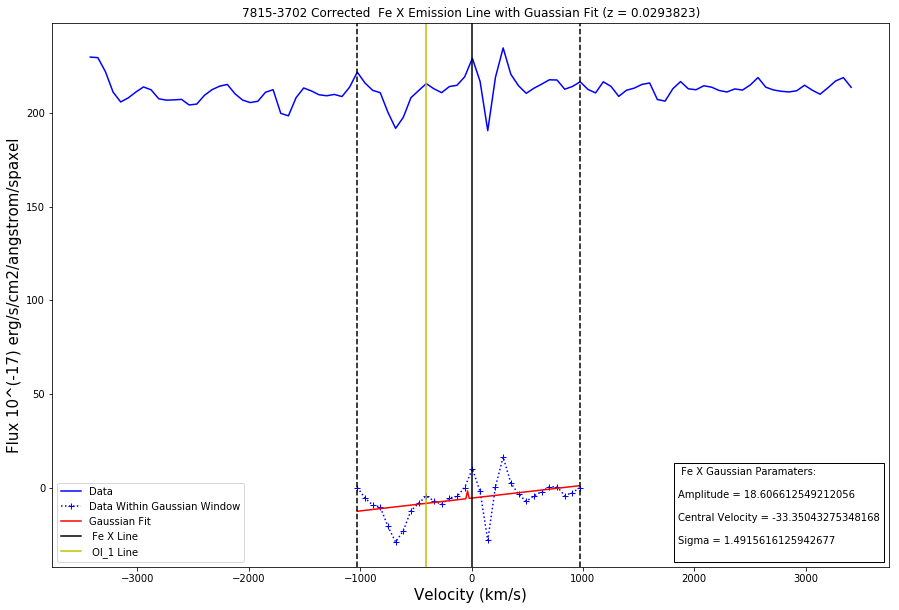

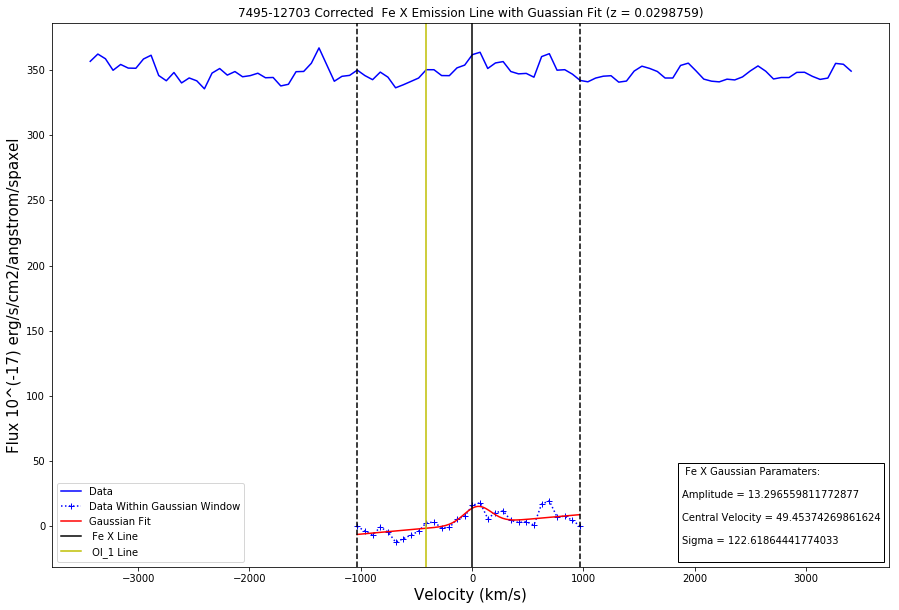

In [63]:
for fitsName in glob.glob('test/*LOGCUBE-VOR10-GAU-MILESHC.fits'):
    hdulist = fits.open(fitsName) #Opening fits file
    flux = hdulist[1].data.sum(axis = (1,2)) #Importing Flux Values 
    wavelength_1 = hdulist[4].data #Importing Wavelength Values
    drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
    tbdata = drpall[1].data #Accessing drpall data
    ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
    c = 299792 #speed of light km/s 
        
    # Defining emission line function
    def emission(emline, number, number2, name2, name6, name8, number10):
        wavelength = wavelength_1/(tbdata['z'][ind][0] + 1)
        wavelength_absolute = np.abs(wavelength - emline) #Determining H-Beta Observed Wavelength
        wavelength_min = np.argmin(wavelength_absolute) #Determining H-Beta Observed Wavelength
        velocity = c*((wavelength - emline)/(emline))
        
        wavelength_oi2 = np.abs(wavelength - OI_2) 
        wavelength_min_oi2 = np.argmin(wavelength_oi2)
        wavelength_oii1 = np.abs(wavelength - OII_1) 
        wavelength_min_oii1 = np.argmin(wavelength_oii1)
        wavelength_oii2 = np.abs(wavelength - OII_2) 
        wavelength_min_oii2 = np.argmin(wavelength_oii2)
        wavelength_oiii3 = np.abs(wavelength - OIII_3) 
        wavelength_min_oiii3 = np.argmin(wavelength_oiii3)
        
        #Spectrum parameters
        w_i = number #Bounds of fit
        z_i = number10 #Wider fit
        y_0 = wavelength_min - w_i #Setting lower bound for linear fit
        y_1 = wavelength_min + w_i #Setting upper bound for linear fit
        z_0 = wavelength_min - z_i #Setting lower bound for linear fit
        z_1 = wavelength_min + z_i #Setting upper bound for linear fit
        flux_scope = flux[z_0:z_1]
        flux_range = flux[y_0:y_1] #Setting range for values to plot
        
        #Performing linear fit
        l_i = number2 #Bounds of fit
        x_0 = wavelength_min - l_i #Setting lower bound for linear fit
        x_1 = wavelength_min + l_i #Setting upper bound for linear fit
        velocity_bounds = velocity[x_0:x_1]
        velocity_mask = np.ma.masked_array(velocity_bounds, 
                                             (velocity_bounds != velocity_bounds[0]) 
                                         & (velocity_bounds != velocity_bounds[-1])) #Masking all but first and last values of the array
        velocity_compressed = velocity_mask.compressed() #Compressing the array to only fit using the two values
        flux_bounds = flux[x_0:x_1] #Determining flux window for linear fit
        flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) #Selecting two points for linear fit.
                                   & (flux_bounds != flux_bounds[-1]))
        flux_compressed = flux_mask.compressed() #Compressing the data
        polyfit_v = np.polyfit(velocity_compressed,flux_compressed, 1) #Fitting the line to the data
        fit_v = np.poly1d(polyfit_v)
        flux_linear_v = fit_v[1]*velocity_bounds + fit_v[0] #Determining linear fit parameters
        flux_correction_v = flux_bounds - flux_linear_v #Correcting for continuum
        
        x_1_2 = x_1 + 2*l_i
        x_1_4 = x_1_2 + 2*l_i
        flux_sigma_bounds_1 = flux[x_1: x_1_2]
        flux_sigma_bounds_2 = flux[x_1_2: x_1_4]
        f_std = np.std(flux_sigma_bounds_1)
        f_std_2 = np.std(flux_sigma_bounds_2)
        flux_sigma_average = (f_std + f_std_2)/2
        flux_sigma = 3*(flux_sigma_average)
        
        if flux_correction_v[l_i] > flux_sigma:
        #Performing Gaussian fit wavelength
            def gaus(x,amp,x0,sigma, m, c):
                return amp*np.exp(-(x-x0)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
            for i in flux_correction_v[l_i:]:
                if i < 0.659*flux_correction_v[l_i]:
                    s = np.abs(flux_correction_v - i)
                    s2 = np.argmin(s)
                    sigma_test = velocity_bounds[s2] - velocity_bounds[l_i]
                    break
            velocity_test = np.arange(velocity_bounds[0],velocity_bounds[29], 15)
            amplitude = np.argmax(flux_correction_v) #Making amplitude prediction
            central_velocity = velocity[wavelength_min] #Making central wavelength prediction
            offset = np.argmin(flux_bounds) #Making offset prediction 
            popt, pcov = curve_fit(gaus,velocity_bounds, #Inputting predictions into fit
                               flux_correction_v, 
                               p0=[flux_correction_v[amplitude], 
                                   central_velocity, sigma_test, fit_v[1], fit_v[0]])

            anchored_gaussian = AnchoredText(name2 + 
                                             'Gaussian Paramaters:' + '\n' +
                                             '\n' + 'Amplitude = ' + str(popt[0]) 
                                   + '\n' + '\n' + 'Central Velocity = ' + str(popt[1]) 
                                   + '\n' + '\n' + 'Sigma = ' + str(popt[2]) + '\n' 
                                   , loc=4)
            velocity_meas = c*((popt[1] - emline)/emline)
            velocity_sys = c*tbdata['z'][ind][0]
            velocity_off = velocity_sys - velocity_meas
            sigma = c*(popt[2]/emline)
            wavelength_range = wavelength[y_0:y_1] #Setting range for values to plot
            wavelength_scope = wavelength[z_0:z_1]
            velocity_range = c*((wavelength_range - emline)/(emline))
            vr_scope = c*((wavelength_scope - emline)/(emline))

    #         f= open(str(name8) + ".txt","a+")
    #         f.write('\t' + fitsName[11:-31] +'\t' + str(round(tbdata['z'][ind][0],3)) + '\t' +
    #                 str(round(popt[0],3)) + '\t' + str(round(velocity_meas, 3)) + '\t' +
    #                 str(round(velocity_sys,3)) + '\t' + str(round(velocity_off,3)) + '\t'
    #                 + str(round(sigma,3)) + '\n') 
    #         f.close() 
            if popt[2] < 849.26:
    #             #Velocity vs Flux
    #             #Assigning folder for each Manga galaxy in desired directory 
    #             newpath = r'/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/velocity_vs_flux/no_threshold/%s/' % fitsName[11:-31] 
    #             if not os.path.exists(newpath):
    #                      os.makedirs(newpath)
                plt.figure(figsize=(15,10))
                plt.plot(vr_scope, flux_scope, 'b', label = 'Data')
                plt.plot(velocity_range, flux_correction_v, 'b+:', label = 'Data Within Gaussian Window')
                plt.plot(velocity_test,
                         gaus(velocity_test, *popt), 'r-', label = 'Gaussian Fit')
                plt.title(fitsName[11:-31] + ' Corrected ' + name2 
                          + 'Emission Line with Guassian Fit' + ' (z = ' + str(tbdata['z'][ind][0]) + ')')
                plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel', fontsize = 15)
                plt.xlabel('Velocity (km/s)', fontsize = 15)
                plt.gca().add_artist(anchored_gaussian)
                plt.axvline(x = velocity[wavelength_min], color = 'k', label = name2 + 'Line')
                if emline == OIII_4:
                    plt.axvline(x = velocity[wavelength_min_oiii3], color = 'c', label = ' OIII_3 Vacuum Wavelength(A) - ' 
                            + str(velocity[wavelength_min_oiii3]))
                if emline == Fe_X:
                    plt.axvline(x = velocity[wavelength_min_oi2], color = 'y', label = ' OI_1 Line ') 
                if emline == Fe_VII_2:
                    plt.axvline(x = velocity[wavelength_min_oii1], color = 'g', label = ' OII_1 Line ') 
                    plt.axvline(x = velocity[wavelength_min_oii2], color = 'm', label = ' OII_2 Line ') 
                plt.axvline(x = velocity[x_0], linestyle = '--', color = 'k')
                plt.axvline(x = velocity[x_1-1], linestyle = '--', color = 'k')
                #plt.xlim(velocity[z_0],velocity[z_1] - 60)
                plt.legend(loc = 3)   
                #dir = '/Users/jmsnegus/Google Drive/Academic/CU/Research/Summer_Research_18/Jupyter/plots/velocity_vs_flux/no_threshold/%s/' % fitsName[11:-31]
                #plt.savefig(dir + fitsName[11:-31] + '_'+ name8 + '.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
                plt.show()
        return;

    # Calling the function
#     emission(emline = H_Beta,  
#              number = 15, 
#              number2 = 15, 
#              name2 = 'H-Beta ', 
#              name6 = 'H-Beta ', 
#              name8 = 'HBeta',
#              number10 = 50)
#     emission(emline = OIII_4, 
#              number = 15, 
#              number2 = 15, 
#              name2 = 'OIII_4 ', 
#              name6 = 'OIII_4 ',
#              name8 = 'OIII_4',
#              number10 = 50)
    emission(emline = Fe_VII_1, 
             number = 15, 
             number2 = 15, 
             name2 = ' Fe VII 1 ', 
             name6 = 'Fe VII 1 ',
             name8 = 'FeVII1',
             number10 = 30)
    emission(emline = Fe_VII_2, 
             number = 15, 
             number2 = 15,  
             name2 = ' Fe VII 2 ', 
             name6 = 'Fe VII 2 ',
             name8 = 'FeVII2',
             number10 = 50)
    emission(emline = Fe_VII_3, 
            number = 15, 
            number2 = 15, 
            name2 = ' Fe VII 3 ', 
            name6 = 'Fe VII 3 ',
            name8 = 'FeVII3',
            number10 = 50)
    emission(emline = Fe_X, 
             number = 15, 
             number2 = 15,  
             name2 = ' Fe X ', 
             name6 = 'Fe X ',
             name8 = 'FeX',
             number10 = 50)
    

In [48]:
# # Plotting Data
# drpall = fits.open('drpall-v2_4_3.fits') #Opening drpall file
# tbdata = drpall[1].data #Accessing drpall data
# h = fits.open('cg/vor10/manga-8249-3704-LOGCUBE-VOR10-GAU-MILESHC.fits')
# ind = np.where(tbdata['mangaid'] == str(h[0].header[59])) #Finding MaNGA ID

# f = h[7].data.sum(axis=(1,2))
# w = (h[4].data)/(tbdata['z'][ind][0] + 1)
# #print (repr(h[0].header))
#tbdata.columns.names

# print (flux_pixel_8138_6101.shape)

#Wavelength vs. Flux 
# plt.plot(w2, f2)
# #plt.ylim(-100,)
# #plt.xlim(4900,5100)
# plt.title('Wavelength vs Flux')
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# #plt.axvline(x = 6600, linestyle = '--', color = 'k', alpha = .5)
# #plt.axvline(x = w2[x], linestyle = '--')
# plt.show()


# #Pixel vs. Flux
# plt.plot(flux_pixel_8138_6101)
# plt.ylim(0,)
# #plt.xlim(1500,1600)
# plt.title('Pixel vs. Flux')
# plt.xlabel('Pixel Number')
# plt.ylabel('Flux 10^(-17) erg/s/cm2/angstrom/spaxel')
# plt.show()

#Pixel to Wavelength Conversion

# pixel = np.arange(1,4564,1)

# plt.plot(w, pixel)
# plt.title ('MaNGA Wavelength to Pixel Conversion')
# plt.xlabel('Wavelength (Angstrom)')
# plt.ylabel('Pixel Number')
# plt.savefig('wavelength_vs_pixel.png', dpi=400, format='png', bbox_inches='tight', pad_inches = 0)
# plt.show()

In [ ]:
# for pixel in range (40, 45, 1): 
#     for pixel_2 in range (40, 45, 1):
#         hdulist_test = fits.open('manga-8138-6101-LOGCUBE-VOR10-GAU-MILESHC.fits')
#         flux_pixel = hdulist_test[1].data[:,pixel,pixel_2]
#         wavelength = hdulist_test[4].data
#         print (flux_pixel)
        